# Treinamento com CVC-ClinicDB, CVC-ColonDB, ETIS-LARIBDB
Este notebook realiza o treinamento usando três bases e aplica Data Augmentation com Albumentations.

In [ ]:
pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 542.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.4/369.4 kB 22.8 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.7
    Uninstalling albumentations-2.0.7:
      Successfully uninstalled albumentations-2.0.7


In [ ]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Imports
import os
import cv2
import skimage
import keras
import random
import numpy as np
import pandas as pd
import albumentations as albu
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
from tqdm import tqdm_notebook
from datetime import datetime
from skimage import morphology
from skimage.io import imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import warnings
warnings.simplefilter("ignore")
plt.style.use("ggplot")
%matplotlib inline

In [ ]:
# Tamanho e batch
IMG_WIDTH, IMG_HEIGHT = 352, 352
BATCH_SIZE = 4

In [ ]:
!cp -r /content/drive/MyDrive/CVC-ClinicDB /content/
!cp -r /content/drive/MyDrive/CVC-ColonDB /content/
!cp -r /content/drive/MyDrive/ETIS-LaribDB /content/

In [ ]:
# Diretórios das bases
train_dirs = [
    '/content/CVC-ClinicDB',
    '/content/CVC-ColonDB',
    '/content/ETIS-LaribDB'
]


In [ ]:
from tensorflow.keras.metrics import Metric
from tensorflow.keras import backend as K

# Define a função para calcular o coeficiente de Dice
def dice_coefficient(y_true, y_pred):
    smooth = 1e-7  # Constante de suavização para evitar divisão por zero
    y_true_f = tf.keras.backend.flatten(y_true)  # Achata o tensor dos rótulos verdadeiros para 1D
    y_pred_f = tf.keras.backend.flatten(y_pred)  # Achata o tensor das previsões para 1D
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)  # Soma da interseção entre rótulos e previsões
    # Fórmula do coeficiente de Dice: 2 * interseção / (soma dos elementos dos dois vetores)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Define a função de Focal Tversky Loss
def focal_tversky_loss(alpha=0.7, beta=0.3, gamma=0.75):
    def loss(y_true, y_pred):
        smooth = 1e-7  # Constante de suavização
        y_true_f = tf.keras.backend.flatten(y_true)  # Achata rótulos verdadeiros
        y_pred_f = tf.keras.backend.flatten(y_pred)  # Achata previsões
        intersection = tf.keras.backend.sum(y_true_f * y_pred_f)  # Verdadeiros positivos
        fn = tf.keras.backend.sum(y_true_f * (1 - y_pred_f))  # Falsos negativos
        fp = tf.keras.backend.sum((1 - y_true_f) * y_pred_f)  # Falsos positivos
        # Cálculo do índice de Tversky ponderando FN e FP
        tversky = (intersection + smooth) / (intersection + alpha * fn + beta * fp + smooth)
        # Aplica a função de perda focal: força o modelo a focar nas regiões mais difíceis
        return tf.keras.backend.pow((1 - tversky), gamma)
    return loss  # Retorna a função de perda configurada

# Define a função para calcular o coeficiente de IoU (Intersection over Union)
def iou_coefficient(y_true, y_pred):
    smooth = 1e-7  # Constante para evitar divisão por zero
    y_true_f = tf.keras.backend.flatten(y_true)  # Achata rótulos verdadeiros
    y_pred_f = tf.keras.backend.flatten(y_pred)  # Achata previsões
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)  # Soma da interseção
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection  # Soma da união
    # Retorna o valor de IoU suavizado
    return (intersection + smooth) / (union + smooth)

# Define a função de perda combinada: Focal Tversky Loss + Binary Crossentropy
def combined_loss(alpha=0.7, beta=0.3, gamma=1.33, ft_weight=0.7, bce_weight=0.3):
    # Obtém a função de perda Focal Tversky configurada
    focal_loss_fn = focal_tversky_loss(alpha=alpha, beta=beta, gamma=gamma)
    def loss(y_true, y_pred):
        ft_loss = focal_loss_fn(y_true, y_pred)  # Calcula a perda Focal Tversky
        bce_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)  # Calcula a perda binária cruzada
        # Retorna a média ponderada das duas perdas
        return ft_weight * ft_loss + bce_weight * bce_loss
    return loss  # Retorna a função de perda combinada

In [ ]:
# Função de pré-processamento com cv2
def preprocess_image_mask(img_path, mask_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = mask / 255.0
    mask = (mask > 0.5).astype(np.float32)

    return image, mask


In [ ]:
# Função para carregar caminhos de imagens e máscaras
def load_dataset_paths(datasets_dirs):
    image_paths = []
    mask_paths = []
    for base_dir in datasets_dirs:
        imgs = sorted(glob(os.path.join(base_dir, 'images', '*.png')))
        masks = sorted(glob(os.path.join(base_dir, 'masks', '*.png')))
        image_paths.extend(imgs)
        mask_paths.extend(masks)
    return image_paths, mask_paths

In [ ]:
def threshold_predictions(preds, threshold=0.3):
    return (preds > threshold).astype(np.uint8)

In [ ]:
# Carrega caminhos
train_image_paths, train_mask_paths = load_dataset_paths(train_dirs)


In [ ]:
#Divide em treino/validação
X_train_paths, X_val_paths, y_train_paths, y_val_paths = train_test_split(train_image_paths, train_mask_paths, test_size=0.1, random_state=42)


In [ ]:
# Aumentações com Albumentations
aug_train = albu.Compose([
    albu.OneOf([
        albu.HorizontalFlip(p=1),
        albu.VerticalFlip(p=1),
        albu.RandomRotate90(p=0.5),
    ], p=0.8),
    albu.OneOf([
        albu.RandomBrightnessContrast(p=1),
        albu.ColorJitter(brightness=0.6, contrast=0.2, saturation=0.1, hue=0.1, p=1),
        albu.CLAHE(p=0.5),
    ], p=0.9),
    albu.OneOf([
        albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1),
        albu.GridDistortion(p=1),
        albu.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1),
    ], p=0.7),
    albu.Affine(
        scale=(0.9, 1.1),
        shear=(-5, 5),
        p=0.9
    ),
    albu.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
], p=1)


In [ ]:
# Gerador com Albumentations e carregamento sob demanda
class AlbumentationsDataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, augment_fn, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.augment_fn = augment_fn
        self.shuffle = shuffle
        self.indices = np.arange(len(image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = []
        batch_masks = []

        for i in batch_indices:
            # Load and resize image and mask without initial normalization
            img = cv2.imread(self.image_paths[i])
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

            # Albumentations works best with uint8 images
            # Ensure image is in RGB format for Albumentations (if using color transforms)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Apply augmentations
            augmented = self.augment_fn(image=img, mask=mask)
            augmented_image = augmented["image"]
            augmented_mask = augmented["mask"]

            # Normalize image and binarize mask after augmentation
            augmented_image = augmented_image / 255.0
            augmented_mask = (augmented_mask > 127).astype(np.float32) # Assuming mask values are 0-255

            batch_images.append(augmented_image)
            batch_masks.append(augmented_mask)

        # Expand mask dimensions
        return np.array(batch_images), np.expand_dims(np.array(batch_masks), axis=-1)


    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)



# **Construção do Modelo**

In [ ]:
# Função para construir a U-Net com EfficientNetB3 como encoder
def build_unet_efficientnetb3(input_shape=(352, 352, 3),dropout=0.1):
    base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=input_shape)

    # Camadas de skip connections
    skips = [
        base_model.get_layer('block1a_activation').output,  # 176x176
        base_model.get_layer('block2b_add').output,         # 88x88
        base_model.get_layer('block3b_add').output,         # 44x44
        base_model.get_layer('block4b_add').output,         # 22x22
    ]
    encoder_output = base_model.get_layer('block6a_activation').output  # 11x11

    # Caminho de expansão (decoder)
    x = encoder_output
    for i, skip in reversed(list(enumerate(skips))):
        x = Conv2DTranspose(256 // (2**i), (3, 3), strides=(2, 2), padding='same')(x)
        x = concatenate([x, skip])
        x = Dropout(dropout)(x)
        x = Conv2D(256 // (2**i), (3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(256 // (2**i), (3, 3), padding='same', activation='relu')(x)
        x = BatchNormalization()(x)

    # Upsample final para 352x352
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model


In [ ]:
# Criação do modelo
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_unet_efficientnetb3(input_shape=input_shape)


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Compila o modelo
model.compile(optimizer='adam', loss=combined_loss(), metrics=[dice_coefficient, iou_coefficient])

In [ ]:
# callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("melhor_modelo.keras", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5, verbose=1),
]


# **Treinamento do Modelo**

In [ ]:
# Instancia geradores
train_generator = AlbumentationsDataGenerator(X_train_paths, y_train_paths, batch_size= BATCH_SIZE, augment_fn=aug_train)
val_generator = AlbumentationsDataGenerator(X_val_paths, y_val_paths, batch_size= BATCH_SIZE, augment_fn=lambda **kwargs: kwargs, shuffle=False)

In [ ]:
%%time
resultados = model.fit(train_generator,
          validation_data=val_generator,
          epochs=150,
          callbacks=callbacks)

Epoch 1/150
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - dice_coefficient: 0.3775 - iou_coefficient: 0.2493 - loss: 0.4446
Epoch 1: val_loss improved from inf to 0.83936, saving model to melhor_modelo.keras
268/268 ━━━━━━━━━━━━━━━━━━━━ 297s 613ms/step - dice_coefficient: 0.3778 - iou_coefficient: 0.2495 - loss: 0.4443 - val_dice_coefficient: 0.0231 - val_iou_coefficient: 0.0119 - val_loss: 0.8394 - learning_rate: 0.0010
Epoch 2/150
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - dice_coefficient: 0.5702 - iou_coefficient: 0.4138 - loss: 0.2763
Epoch 2: val_loss did not improve from 0.83936
268/268 ━━━━━━━━━━━━━━━━━━━━ 89s 330ms/step - dice_coefficient: 0.5703 - iou_coefficient: 0.4139 - loss: 0.2762 - val_dice_coefficient: 2.1512e-06 - val_iou_coefficient: 1.0757e-06 - val_loss: 1.7307 - learning_rate: 0.0010
Epoch 3/150
268/268 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - dice_coefficient: 0.6089 - iou_coefficient: 0.4563 - loss: 0.2488
Epoch 3: val_loss did not improve from 0.83936
268/268 ━━━━

In [ ]:

model.save("modelo_multibase.keras")

# **Avaliação do Modelo**

In [ ]:
def plotar_resultado_treinamento(historico):
    """
    Plota curvas de loss, Dice coefficient e IoU durante o treinamento.
    """
    loss = historico.history['loss']
    val_loss = historico.history['val_loss']

    dice = historico.history.get('dice_coefficient')
    val_dice = historico.history.get('val_dice_coefficient')

    iou = historico.history.get('iou_coefficient')
    val_iou = historico.history.get('val_iou_coefficient')

    epocas = range(1, len(loss) + 1)

    plt.figure(figsize=(18, 5))

    # Subplot 1: Loss
    plt.subplot(1, 3, 1)
    plt.plot(epocas, loss, label='Treino')
    plt.plot(epocas, val_loss, label='Validação')
    plt.plot(np.argmin(val_loss), np.min(val_loss), 'ro', label='Melhor Val. Loss')
    plt.title('Loss por Época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Subplot 2: Dice Coefficient (se disponível)
    if dice and val_dice:
        plt.subplot(1, 3, 2)
        plt.plot(epocas, dice, label='Treino')
        plt.plot(epocas, val_dice, label='Validação')
        plt.plot(np.argmax(val_dice), np.max(val_dice), 'go', label='Melhor Val. Dice')
        plt.title('Dice Coefficient por Época')
        plt.xlabel('Épocas')
        plt.ylabel('Dice Coefficient')
        plt.grid(True)
        plt.legend()

    # Subplot 3: IoU Coefficient (se disponível)
    if iou and val_iou:
        plt.subplot(1, 3, 3)
        plt.plot(epocas, iou, label='Treino')
        plt.plot(epocas, val_iou, label='Validação')
        plt.plot(np.argmax(val_iou), np.max(val_iou), 'bo', label='Melhor Val. IoU')
        plt.title('IoU Coefficient por Época')
        plt.xlabel('Épocas')
        plt.ylabel('IoU Coefficient')
        plt.grid(True)
        plt.legend()

    plt.suptitle("Curvas de Aprendizado", fontsize=16)
    plt.tight_layout()
    plt.show()

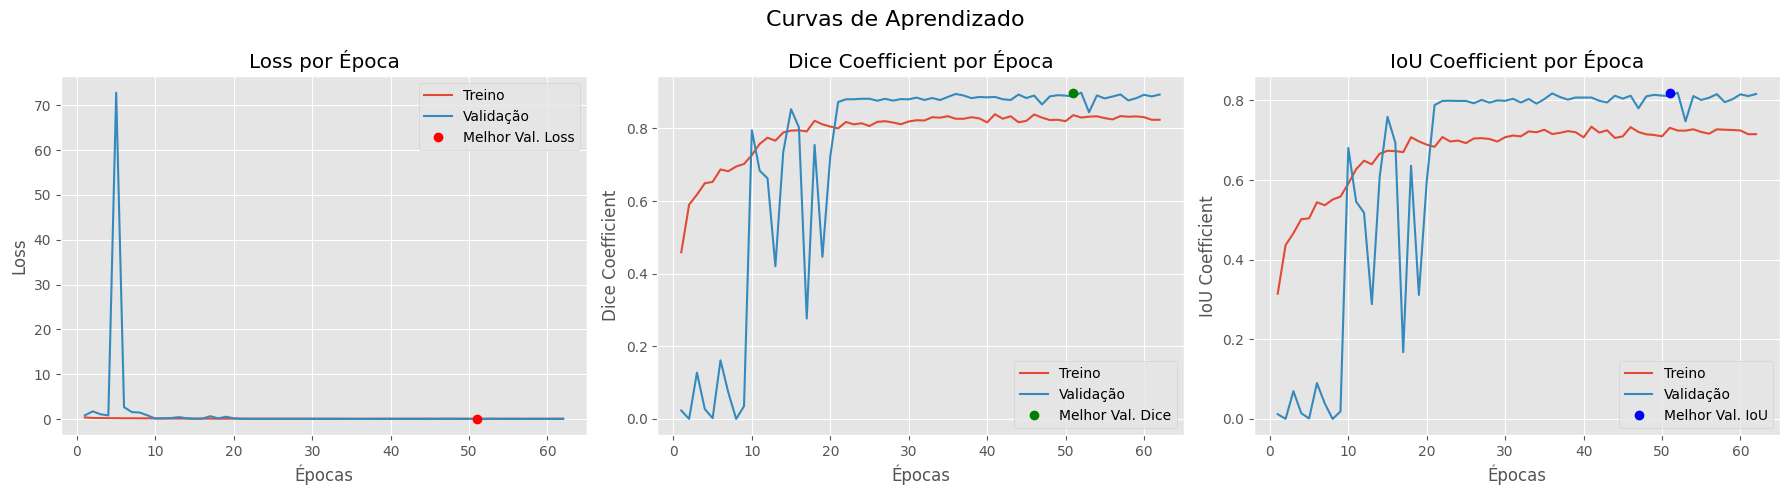

In [ ]:
plotar_resultado_treinamento(resultados)

# **Avaliação do Modelo no Kvasir-SEG**

In [ ]:
# Avaliação no Kvasir-SEG
kvasir_image_dir = "/content/drive/MyDrive/kvasir-seg/Kvasir-SEG/images"
kvasir_mask_dir = "/content/drive/MyDrive/kvasir-seg/Kvasir-SEG/masks"

In [ ]:
kvasir_image_paths = sorted(glob(os.path.join(kvasir_image_dir, '*.jpg')))
kvasir_mask_paths = sorted(glob(os.path.join(kvasir_mask_dir, '*.jpg')))

In [ ]:
# Métricas de avaliação
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
ious, dices, accs, precs, recalls = [], [], [], [], []

In [ ]:
for img_path, mask_path in tqdm_notebook(zip(kvasir_image_paths, kvasir_mask_paths), total=len(kvasir_image_paths)):
    image, mask = preprocess_image_mask(img_path, mask_path)
    image_input = np.expand_dims(image, axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# Previsões
pred = model.predict(image_input)[0, :, :, 0]
pred = threshold_predictions(pred, threshold=0.3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [ ]:
flat_pred = pred.flatten()
flat_mask = mask.flatten()

In [ ]:
 # Métricas
ious.append(jaccard_score(flat_mask, flat_pred))
dices.append(f1_score(flat_mask, flat_pred))
accs.append((flat_mask == flat_pred).mean())
precs.append(precision_score(flat_mask, flat_pred))
recalls.append(recall_score(flat_mask, flat_pred))

In [ ]:
## Resultados Médios
print("--- Avaliação no Kvasir-SEG ---")
print(f"IoU Médio: {np.mean(ious):.4f}")
print(f"Dice Médio: {np.mean(dices):.4f}")
print(f"Acurácia Média: {np.mean(accs):.4f}")
print(f"Precisão Média: {np.mean(precs):.4f}")
print(f"Recall Médio: {np.mean(recalls):.4f}")

--- Avaliação no Kvasir-SEG ---
IoU Médio: 0.7124
Dice Médio: 0.8321
Acurácia Média: 0.9892
Precisão Média: 0.9979
Recall Médio: 0.7135


In [ ]:
all_true_masks = []
all_pred_masks = []

In [ ]:
# Anexa a máscara e a predição às listas para o cálculo da matriz de confusão.
all_true_masks.append(flat_mask) # Achatar para um array 1D para concatenação.
all_pred_masks.append(flat_pred) # Achatar para um array 1D para concatenação.

In [ ]:
y_true_flat = np.concatenate(all_true_masks)
preds_flat = np.concatenate(all_pred_masks)

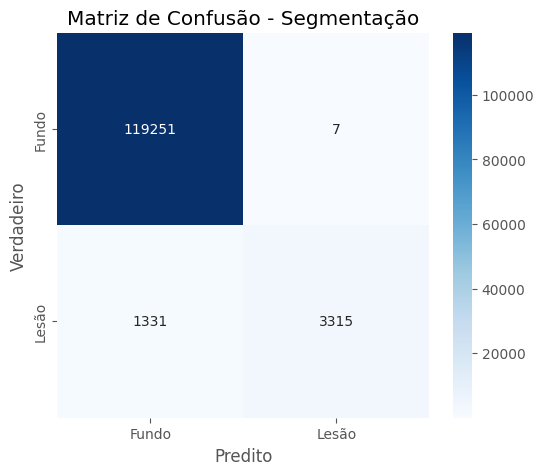

In [ ]:
# Matriz de confusão
import seaborn as sns
cm = confusion_matrix(y_true_flat, preds_flat)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fundo', 'Lesão'], yticklabels=['Fundo', 'Lesão'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Segmentação')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


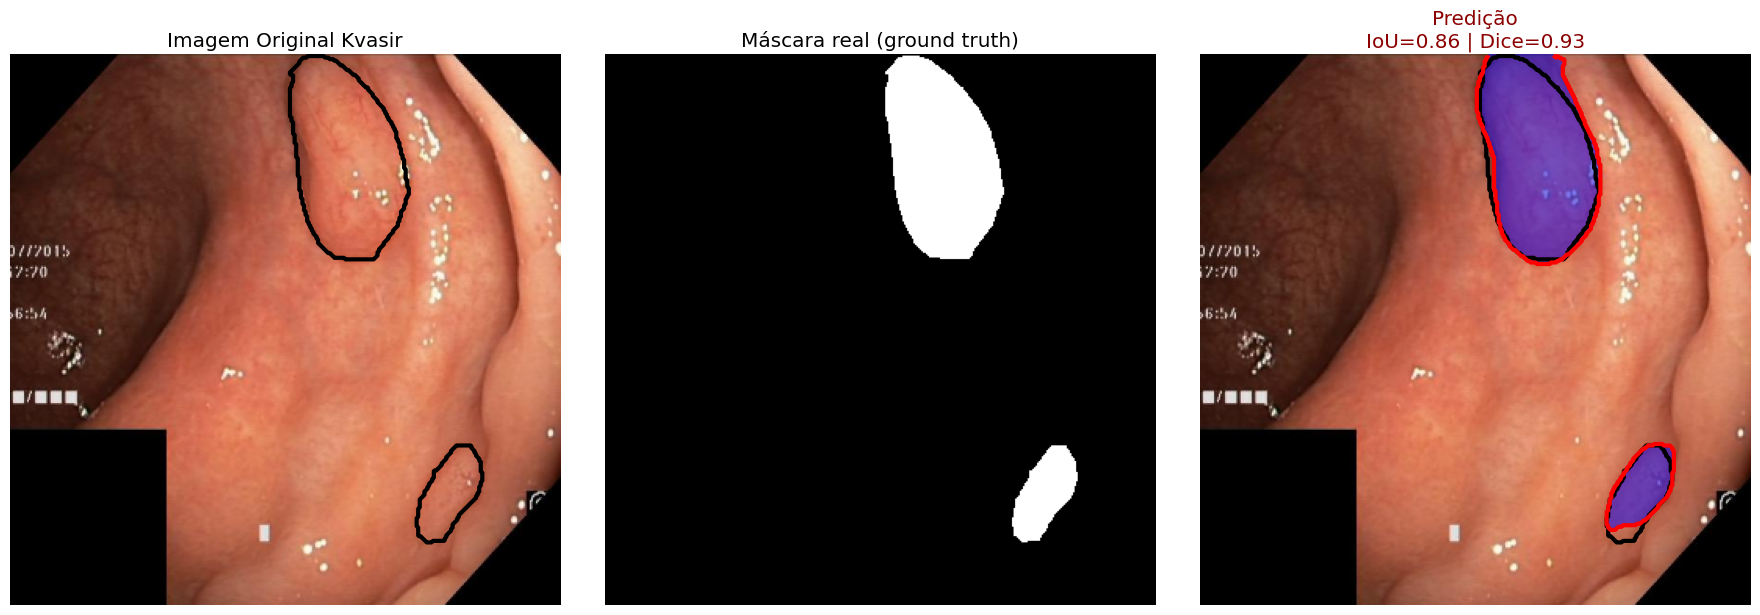

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


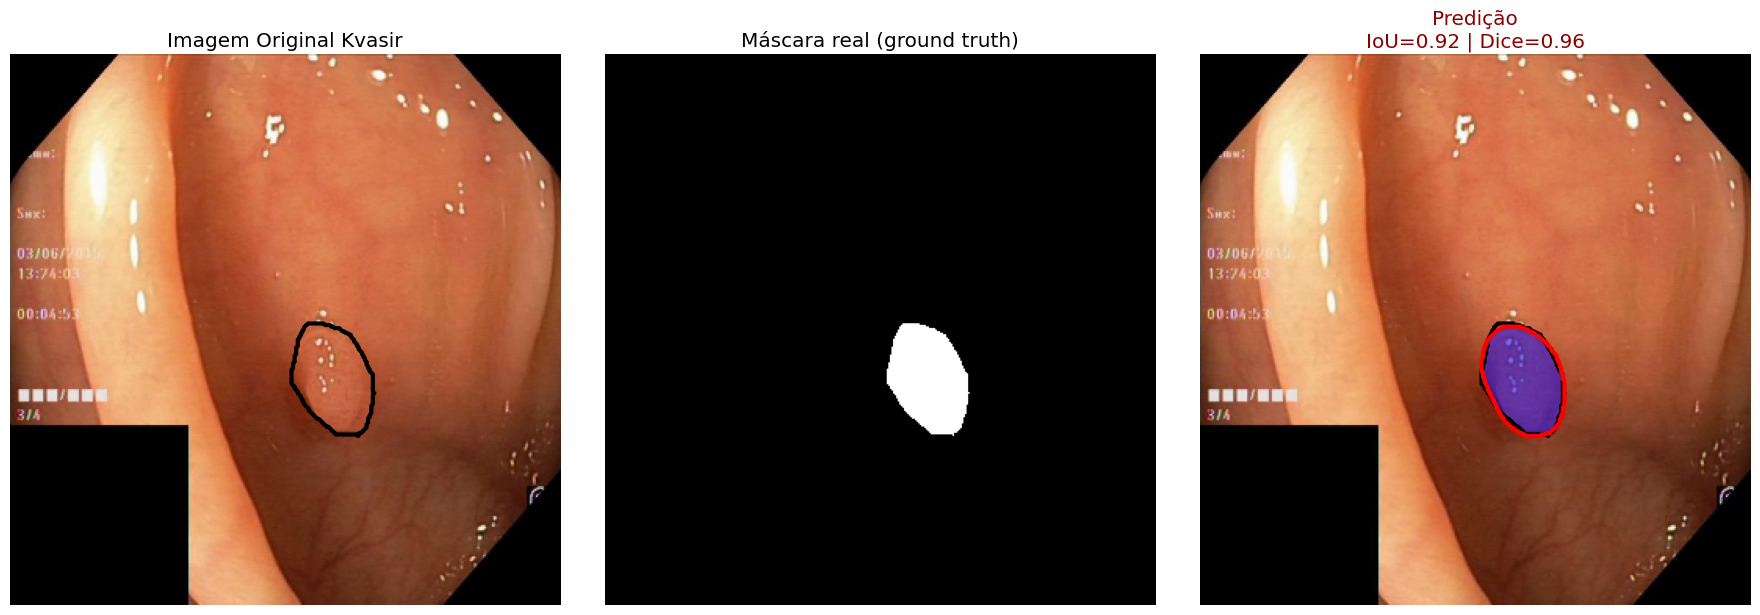

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


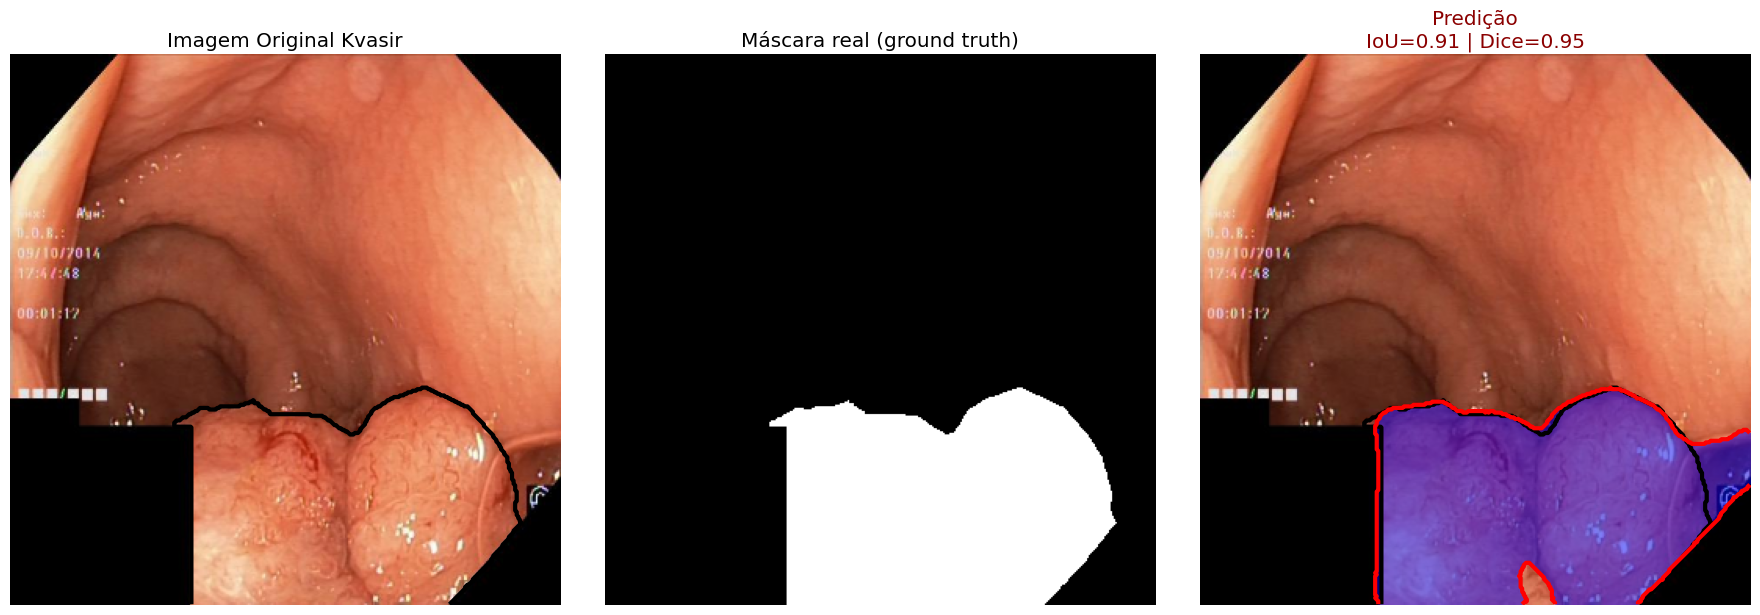

In [ ]:
import random
FIXED_THRESHOLD = 0.3 # ajuste conforme necessário

# Função para Dice
def compute_dice(gt, pred):
    intersection = np.logical_and(gt, pred)
    return 2. * intersection.sum() / (gt.sum() + pred.sum() + 1e-6)

# Loop para visualizar 3 amostras aleatórias
for _ in range(3):
    idx = random.randint(0, len(kvasir_image_paths) - 1)

    # --- Imagem original (convertida de BGR para RGB) ---
    img_bgr = cv2.imread(kvasir_image_paths[idx])
    img_bgr = cv2.resize(img_bgr, (IMG_WIDTH, IMG_HEIGHT))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # --- Máscara ground truth ---
    gt_mask = cv2.resize(cv2.imread(kvasir_mask_paths[idx], cv2.IMREAD_GRAYSCALE), (IMG_WIDTH, IMG_HEIGHT))
    gt_mask = (gt_mask > 127).astype(np.uint8)

    # --- Predição contínua e binarização com threshold fixo ---
    pred_raw = model.predict(np.expand_dims(img_rgb / 255.0, axis=0))[0, :, :, 0]
    pred_mask = (pred_raw > FIXED_THRESHOLD).astype(np.uint8)

    # --- Métricas ---
    if gt_mask.sum() + pred_mask.sum() == 0:
        dice = 1.0
        iou = 1.0
    else:
        intersection = np.logical_and(gt_mask, pred_mask)
        dice = 2. * intersection.sum() / (gt_mask.sum() + pred_mask.sum())
        iou = jaccard_score(gt_mask.flatten(), pred_mask.flatten())

    # --- Visualização ---
    plt.figure(figsize=(18, 6))

    # Imagem com contorno do GT
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.contour(gt_mask, colors='k', linewidths=3, levels=[0.5])
    plt.title("Imagem Original Kvasir")
    plt.axis('off')

    # Máscara GT
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Máscara real (ground truth)")
    plt.axis('off')

    # Predição com contornos
    plt.subplot(1, 3, 3)
    overlay = img_rgb.copy().astype(np.float32) / 255.0
    blue_mask = np.zeros_like(overlay)
    blue_mask[:, :, 2] = 1.0  # azul
    mask_area = pred_mask > 0
    overlay[mask_area] = 0.5 * overlay[mask_area] + 0.5 * blue_mask[mask_area]
    plt.imshow(overlay)
    plt.contour(gt_mask, colors='k', linewidths=3, levels=[0.5])
    plt.contour(pred_mask, colors='red', linewidths=3, levels=[0.5])
    plt.title(f"Predição\nIoU={iou:.2f} | Dice={dice:.2f}", color='darkred')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.metrics import jaccard_score

def visualizar_predicao(idx, model, kvasir_image_paths, kvasir_mask_paths, threshold=0.3):
    """
    Visualiza a predição do modelo para uma imagem específica do conjunto de validação.

    Parâmetros:
        idx (int): índice da imagem a ser visualizada.
        model (tf.keras.Model): modelo treinado.
        kvasir_image_paths (list): caminhos das imagens de validação.
        kvasir_mask_pathsl (list): caminhos das máscaras de validação.
        threshold (float): limiar para binarização da predição.
    """
    # --- Carrega imagem RGB ---
    img_bgr = cv2.imread(kvasir_image_paths[idx])
    img_bgr = cv2.resize(img_bgr, (IMG_WIDTH, IMG_HEIGHT))
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_input = img_rgb.astype(np.float32) / 255.0

    # --- Ground truth ---
    gt_mask = cv2.imread(kvasir_mask_paths[idx], cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, (IMG_WIDTH, IMG_HEIGHT))
    gt_mask = (gt_mask > 127).astype(np.uint8)

    # --- Predição e limiarização ---
    pred_raw = model.predict(np.expand_dims(img_input, axis=0), verbose=0)[0, :, :, 0]
    pred_mask = (pred_raw > threshold).astype(np.uint8)

    # --- Métricas ---
    if gt_mask.sum() + pred_mask.sum() == 0:
        dice = 1.0
        iou = 1.0
    else:
        intersection = np.logical_and(gt_mask, pred_mask)
        dice = 2. * intersection.sum() / (gt_mask.sum() + pred_mask.sum() + 1e-6)
        iou = jaccard_score(gt_mask.flatten(), pred_mask.flatten())

    # --- Visualização ---
    plt.figure(figsize=(18, 6))

    # Imagem original com contorno GT
    plt.subplot(1, 3, 1)
    plt.imshow(img_rgb)
    plt.contour(gt_mask, colors='k', linewidths=2, levels=[0.5])
    plt.title("Imagem Original")
    plt.axis('off')

    # Máscara Ground Truth
    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Máscara Real (GT)")
    plt.axis('off')

    # Predição com sobreposição
    plt.subplot(1, 3, 3)
    overlay = img_rgb.astype(np.float32) / 255.0
    blue_mask = np.zeros_like(overlay)
    blue_mask[:, :, 2] = 1.0  # Azul
    overlay[pred_mask > 0] = 0.5 * overlay[pred_mask > 0] + 0.5 * blue_mask[pred_mask > 0]
    plt.imshow(overlay)
    plt.contour(gt_mask, colors='k', linewidths=2, levels=[0.5])
    plt.contour(pred_mask, colors='red', linewidths=2, levels=[0.5])
    plt.title(f"Predição\nIoU = {iou:.2f} | Dice = {dice:.2f}", color='darkred')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

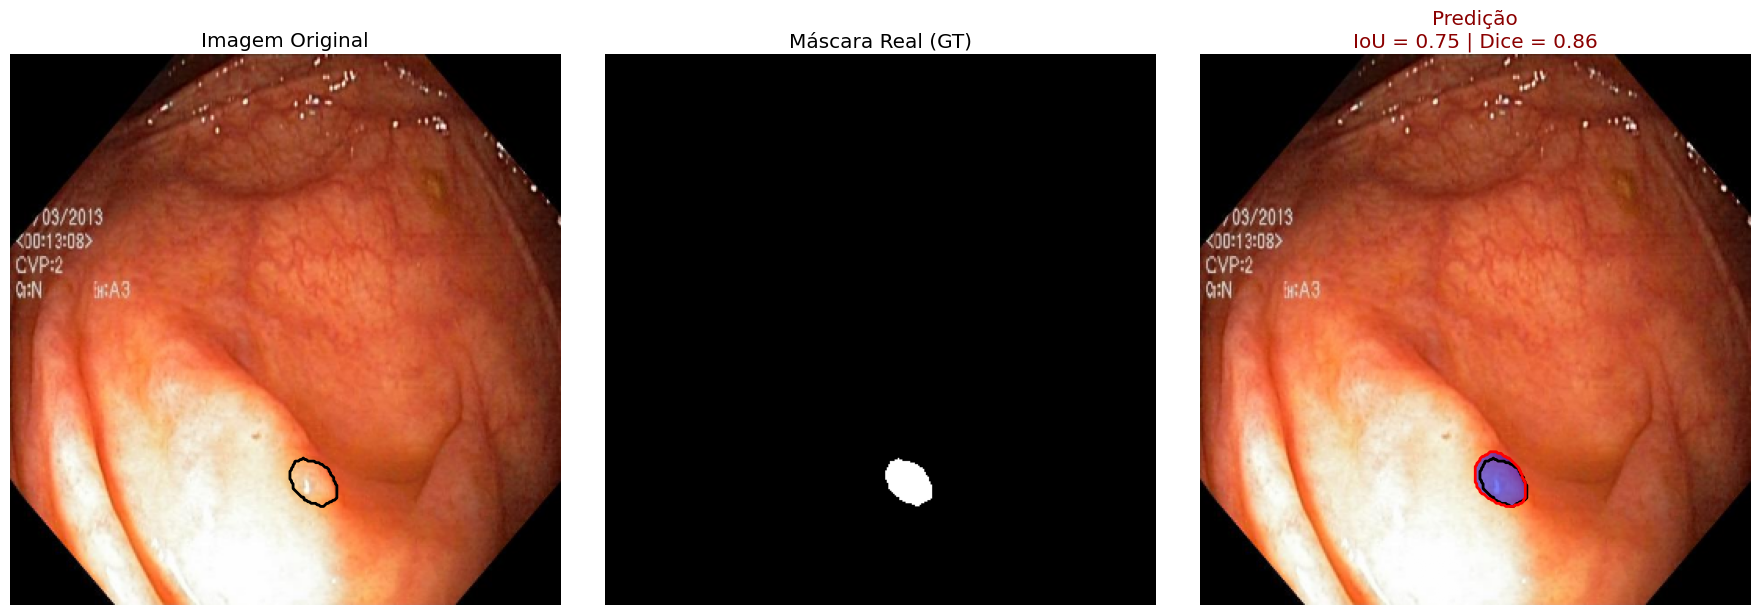

In [ ]:
visualizar_predicao(10, model, kvasir_image_paths, kvasir_mask_paths)

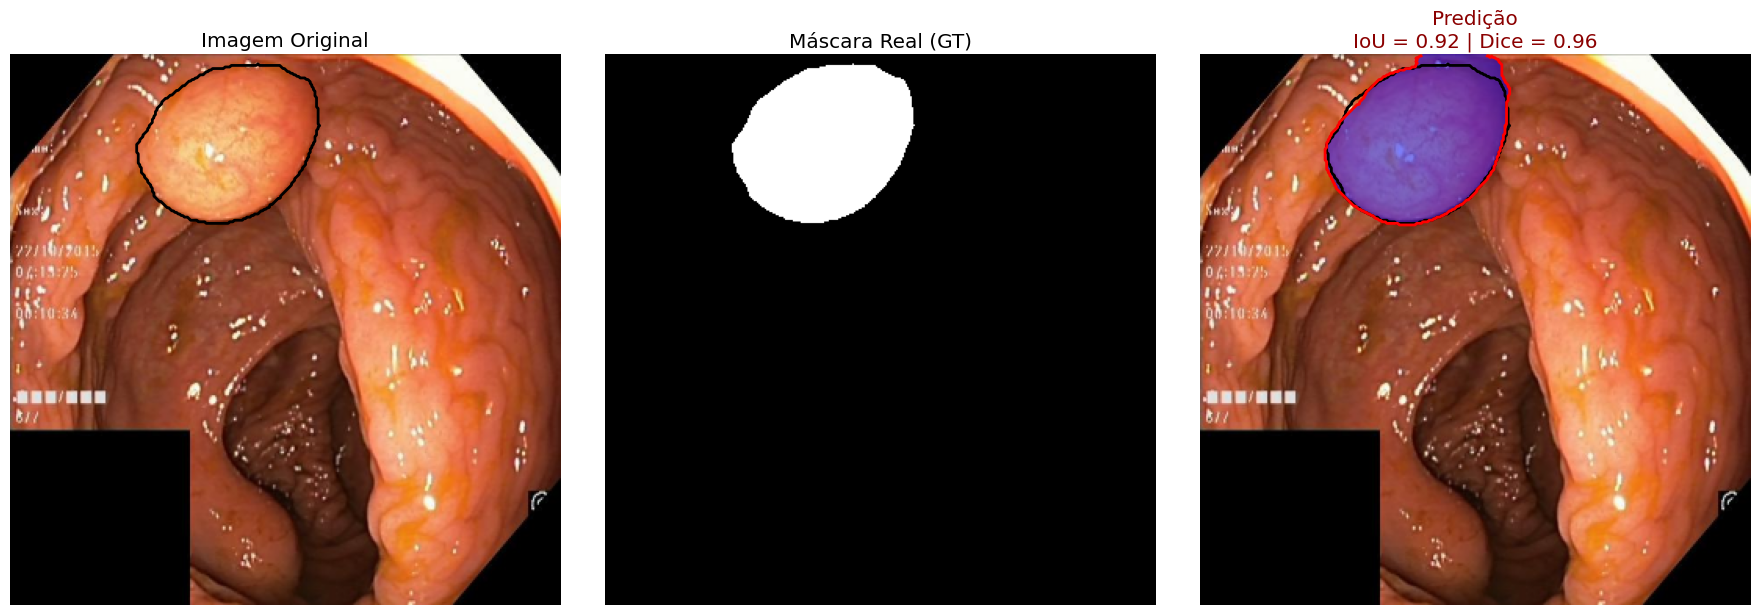

In [ ]:
visualizar_predicao(20, model, kvasir_image_paths, kvasir_mask_paths)

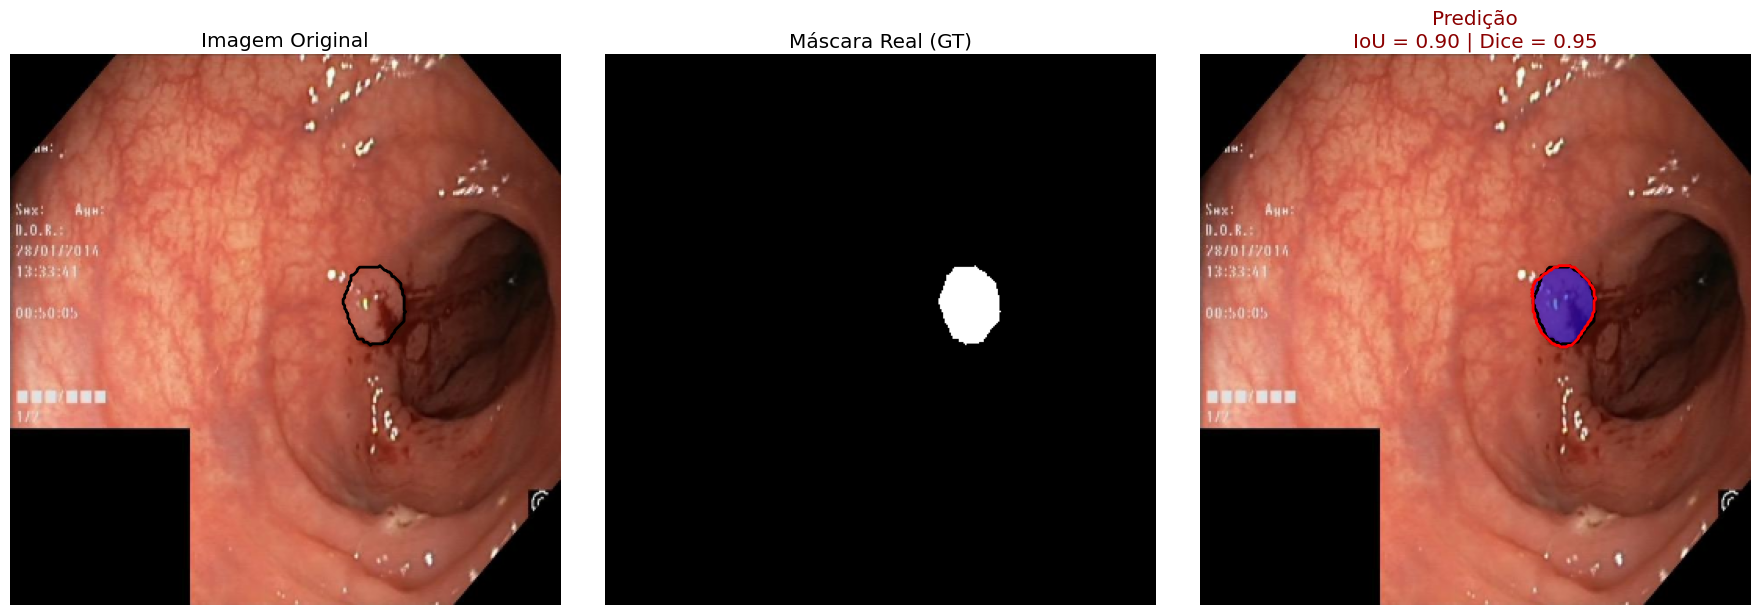

In [ ]:
visualizar_predicao(40, model, kvasir_image_paths, kvasir_mask_paths)

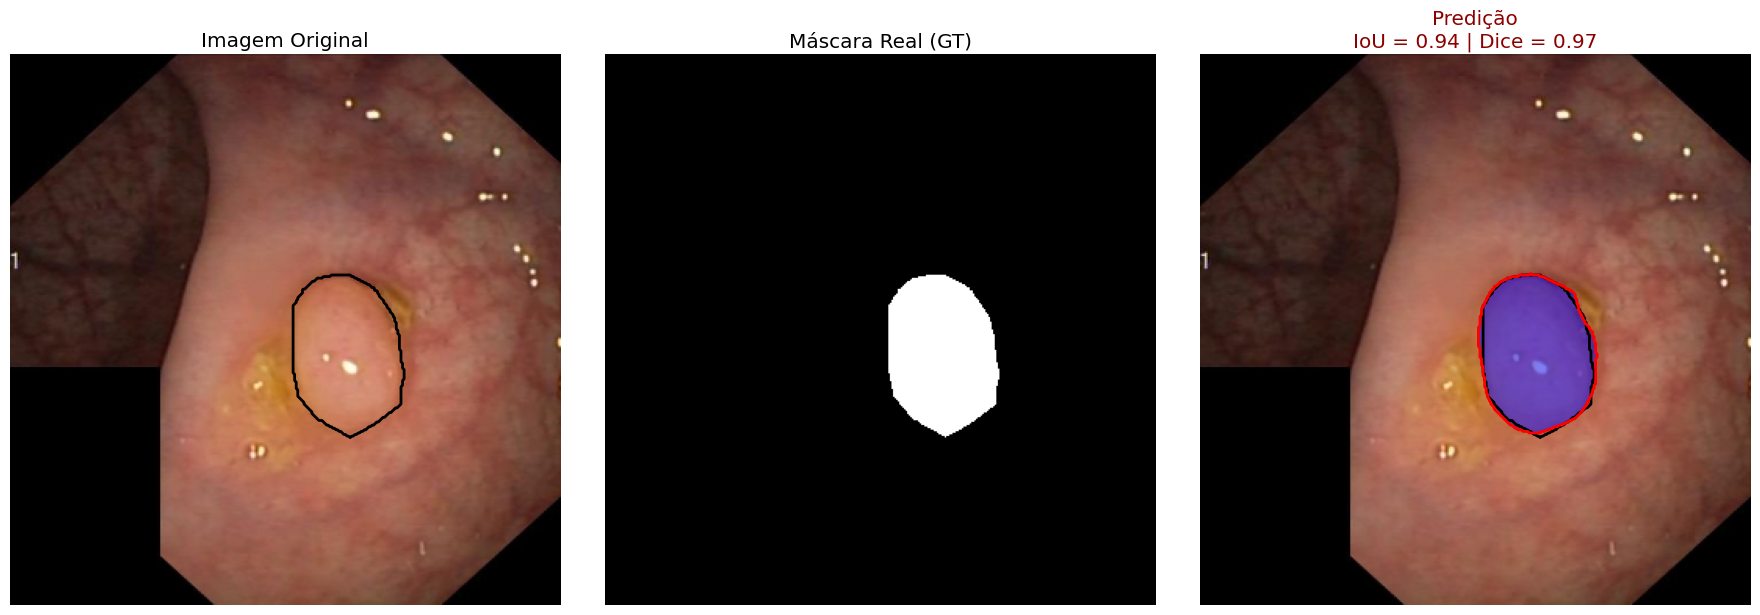

In [ ]:
visualizar_predicao(30, model, kvasir_image_paths, kvasir_mask_paths)

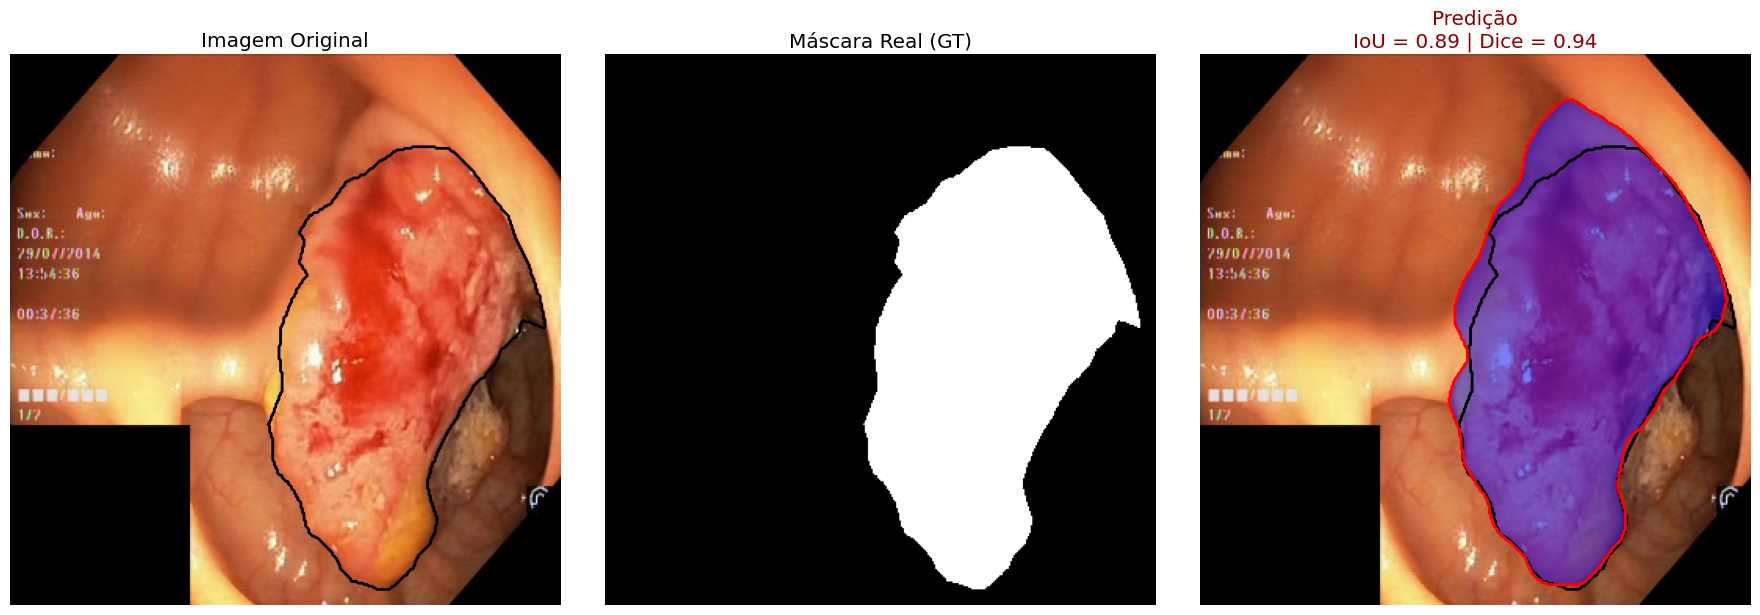

In [ ]:
visualizar_predicao(12, model, kvasir_image_paths, kvasir_mask_paths)

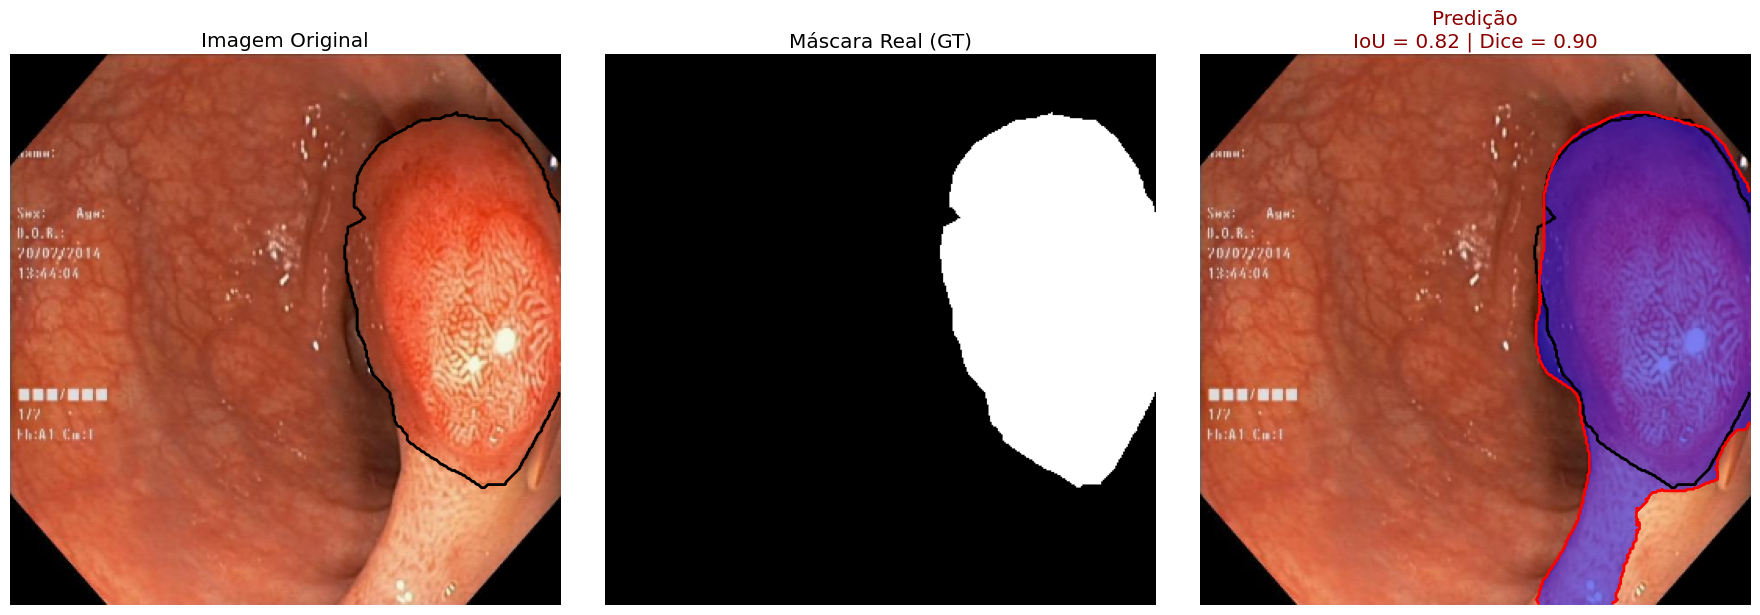

In [ ]:
visualizar_predicao(5, model, kvasir_image_paths, kvasir_mask_paths)

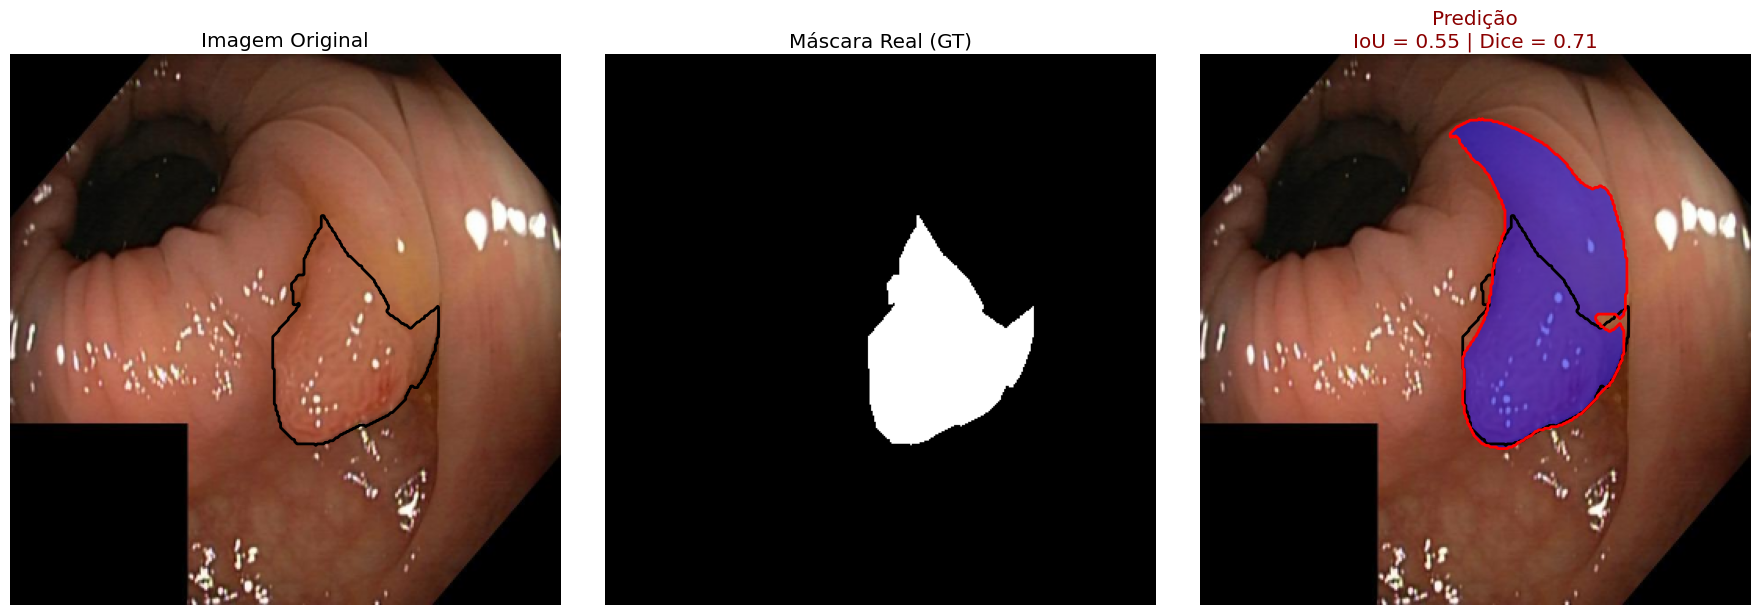

In [ ]:
visualizar_predicao(4, model, kvasir_image_paths, kvasir_mask_paths)

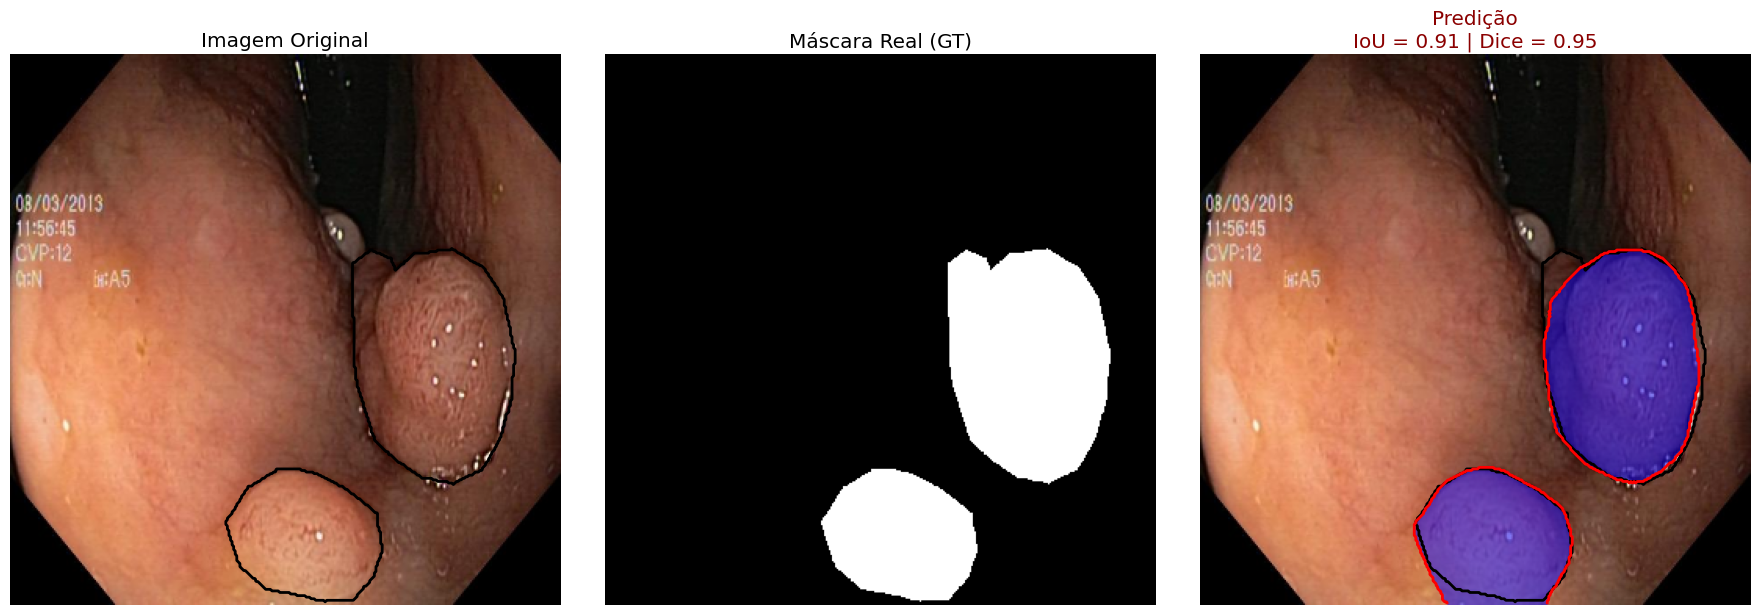

In [ ]:
visualizar_predicao(45, model, kvasir_image_paths, kvasir_mask_paths)

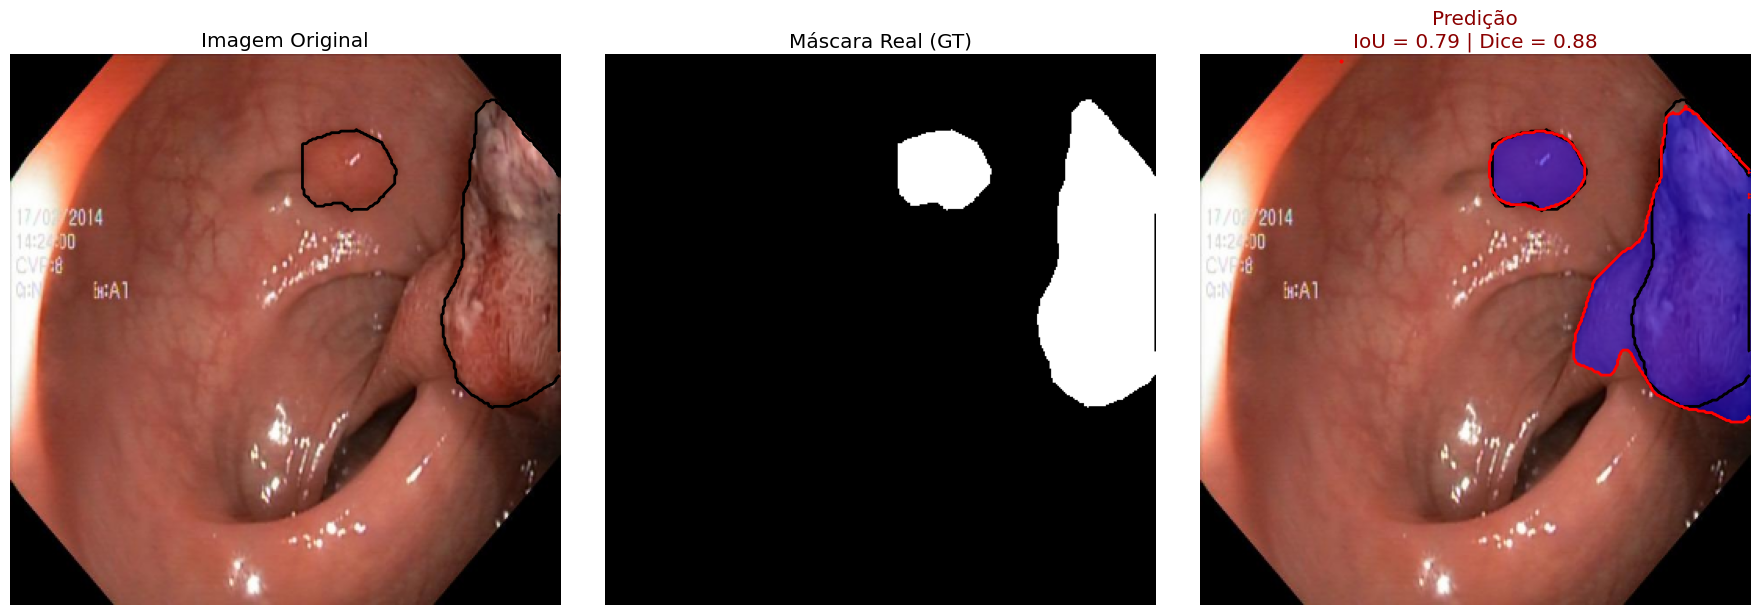

In [ ]:
visualizar_predicao(3, model, kvasir_image_paths, kvasir_mask_paths)

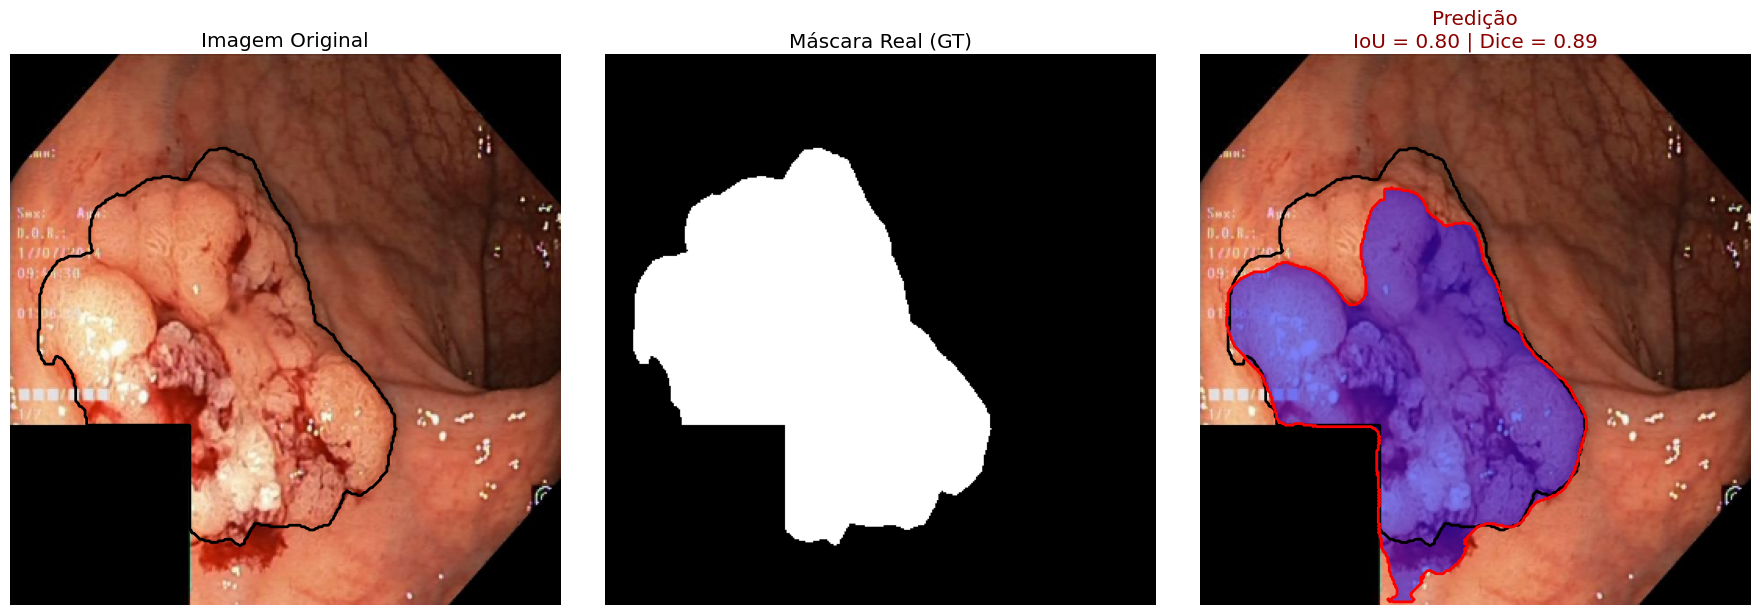

In [ ]:
visualizar_predicao(21, model, kvasir_image_paths, kvasir_mask_paths)

# **Fim**

# 🖼️ **Painéis apresentados:**
**Imagem Original (Kvasir_SEG)**

Mostra a lesão com seu contorno verdadeiro em preto.

**Ground Truth**

Máscara binária da segmentação real, também com o contorno em preto.

**Predição do Modelo**

Contém a predição sobreposta na imagem:

**Região em azul**: área predita como lesão.

**Contorno vermelho**: contorno da predição.

**Contorno preto**: contorno da ground truth.

# **CONCLUSÕES**


| Métrica            | Valor  | Interpretação                                                       |
| ------------------ | ------ | ------------------------------------------------------------------- |
| **IoU Médio**      | 0.7124 | Bom — o modelo consegue identificar com precisão a maior parte das regiões-alvo, com mais de 70\% de sobreposição entre as predições e as máscaras reais,mas ainda perde parte das estruturas reais.           |
| **Dice Médio**     |0.8321| Bom — indica uma sobreposição consistente entre as regiões segmentadas e as regiões reais, refletindo boa sensibilidade e precisão combinadas.
| **Acurácia Média** | 0.9892 | Alta — o modelo classifica corretamente a maioria dos pixels (principalmente fundo).
| **Precisão Média** | 0.9979| Excelente — quando o modelo detecta lesão, quase sempre está correto, indicando baixíssima taxa de falsos positivos.
| **Recall Médio**   | 0.7135 | Moderado — o modelo detecta boa parte das lesões reais, mas ainda perde algumas regiões menores ou mais difíceis de segmentar.


# **🩺 Diagnóstico do Modelo**

*   O modelo apresentou boa capacidade de generalização ao ser testado em um conjunto diferente dos dados de treino.

*   Alta precisão (0.9979) e alta acurácia (0.9892) indicam que o modelo tem baixa taxa de falsos positivos, ou seja, raramente detecta regiões erradas.
